In [1]:
################################################################
# (c) Lars Tijssen
# last edit: 24-10-2017
# We have a database full of youtube comments, some of which are labeled spam
# Can we build a model to predict if a youtube comment is spam or not
################################################################

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from sklearn import cross_decomposition
import string

In [2]:
# Load in the data

basepath = "F://Downloads//youtube_spam//"
data1 = pd.read_csv(basepath + "Youtube01-Psy.csv")
data2 = pd.read_csv(basepath + "Youtube02-KatyPerry.csv")
data3 = pd.read_csv(basepath + "Youtube03-LMFAO.csv")
data4 = pd.read_csv(basepath + "Youtube04-Eminem.csv")
data5 = pd.read_csv(basepath + "Youtube05-Shakira.csv")

datalist = [data1,data2,data3,data4,data5]
data = pd.concat(datalist, ignore_index = True)

In [3]:
# select only the data that we need
data = data[['CONTENT','CLASS']]

In [26]:
# First lets try building our model using metadata from the text

data['CONTENT_LENGTH'] = data['CONTENT'].apply(len)
data['CAPITAL_COUNT'] = [sum([letter.isupper() for letter in x]) for x in data['CONTENT']]
data['PUNCTUATION_COUNT'] = [len([letter for letter in x if letter in string.punctuation]) for x in data['CONTENT']]

data.head()

,CONTENT,CLASS,CONTENT_LENGTH,CAPITAL_COUNT,PUNCTUATION_COUNT
0,"Huh, anyway check out this you[tube] channel: ...",1,56,1,4
1,Hey guys check out my new channel and our firs...,1,166,20,9
2,just for test I have to say murdev.com,1,38,1,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,50,0,3
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,41,6,3


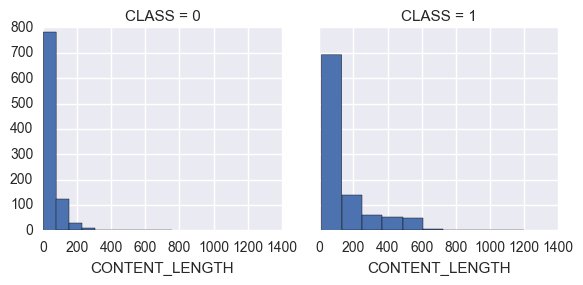

In [7]:
g = sns.FacetGrid(data,col='CLASS')
g.map(plt.hist,'CONTENT_LENGTH')

# we can see that spam (class 1) is typically longer in text than ham (class 0)

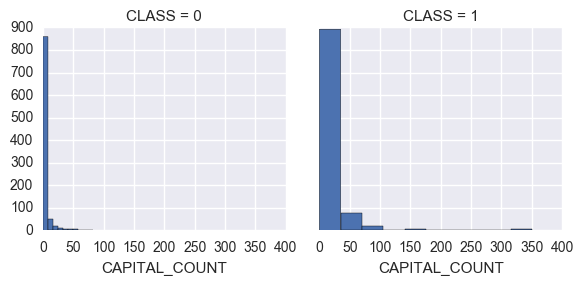

In [8]:
g = sns.FacetGrid(data,col='CLASS')
g.map(plt.hist,'CAPITAL_COUNT')

# lets use a logistic model to train our data on and see if its any good

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(data[['CONTENT_LENGTH','CAPITAL_COUNT','PUNCTUATION_COUNT']], data['CLASS'], 
                                                    test_size=0.3,random_state=101)

lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[226  49]
 [163 149]]


             precision    recall  f1-score   support

          0       0.58      0.82      0.68       275
          1       0.75      0.48      0.58       312

avg / total       0.67      0.64      0.63       587



# it seems that our model is good in identifying ham (recall = 0.82) but not in spam (recall = 0.48). Even randomly guessing works better

In [62]:
# now lets see if we can build a model that actually uses the content of the text to discern between spam and ham
# lets process the text first to prepare it

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in nltk.corpus.stopwords.words('english')]

data2 = data['CONTENT'].apply(text_process)

F:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [73]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

X = data2.map(lambda x: ' '.join(x))
y = data['CLASS']

X = cv.fit_transform(X)

X

<1956x4191 sparse matrix of type '<type 'numpy.int64'>'
	with 15444 stored elements in Compressed Sparse Row format>

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [75]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

nb.fit(X_train,y_train)

predictions = nb.predict(X_test)

from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[245  30]
 [ 56 256]]


             precision    recall  f1-score   support

          0       0.81      0.89      0.85       275
          1       0.90      0.82      0.86       312

avg / total       0.86      0.85      0.85       587



# our results look much better now
# we can even improve more by including puncuation but at the cost of a bigger countvector

In [77]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

X = data['CONTENT']
y = data['CLASS']

X = cv.fit_transform(X)

X

<1956x4452 sparse matrix of type '<type 'numpy.int64'>'
	with 25764 stored elements in Compressed Sparse Row format>

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [79]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

nb.fit(X_train,y_train)

predictions = nb.predict(X_test)

from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[247  28]
 [ 25 287]]


             precision    recall  f1-score   support

          0       0.91      0.90      0.90       275
          1       0.91      0.92      0.92       312

avg / total       0.91      0.91      0.91       587

